In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm
import dlib
import time
import imutils
from imutils import face_utils

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Set the paths for training and testing data
train_data_dir = 'Latest Dataset/Train'
test_data_dir = 'Latest Dataset/Test'
CATEGORIES = ["Anger", "Joy", "Natural", "Sadness"]
IMG_SIZE = 128

# Define image size and batch size
img_size = (128, 128)
batch_size = 16

In [3]:
def detect_face(image_path, face_cascade):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    if len(faces) == 0:
        return None
    (x, y, w, h) = faces[0]  # Assuming one face per image
    face = gray[y:y+h, x:x+w]
    return cv2.resize(face, (128, 128))  # Resize to a fixed size

In [4]:
# Initialize the Haar Cascade
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

**Preprocess Dataset**

In [5]:
features = []
labels = []

for label, category in enumerate(CATEGORIES):
    class_dir = os.path.join(train_data_dir, category)
    if not os.path.isdir(class_dir):
        continue

    for image_name in os.listdir(class_dir):
        image_path = os.path.join(class_dir, image_name)
        face = detect_face(image_path, face_cascade)
        
        if face is not None:
            features.append(face.flatten())
            labels.append(label)

images = np.array(features)
labels = np.array(labels)

In [18]:
# Convert lists to numpy arrays
features = np.array(features)
labels = np.array(labels)

# Normalize the data
scaler = StandardScaler()
features = scaler.fit_transform(features)

In [20]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42, shuffle=True, stratify=labels)

## Feature Extraction - Linear Discriminant Analysis (LDA)

**Computational Performance Metrics (Time)**

In [25]:
start_time = time.time()

lda = LinearDiscriminantAnalysis(n_components=len(CATEGORIES) - 1)
X_train_lda = lda.fit_transform(X_train, y_train)
X_test_lda = lda.transform(X_test)

end_time = time.time()
execution_time = end_time - start_time
print(f'Feature extraction time: {execution_time} seconds')

Feature extraction time: 1.1066265106201172 seconds


In [9]:
X_train_lda.shape

(416, 3)

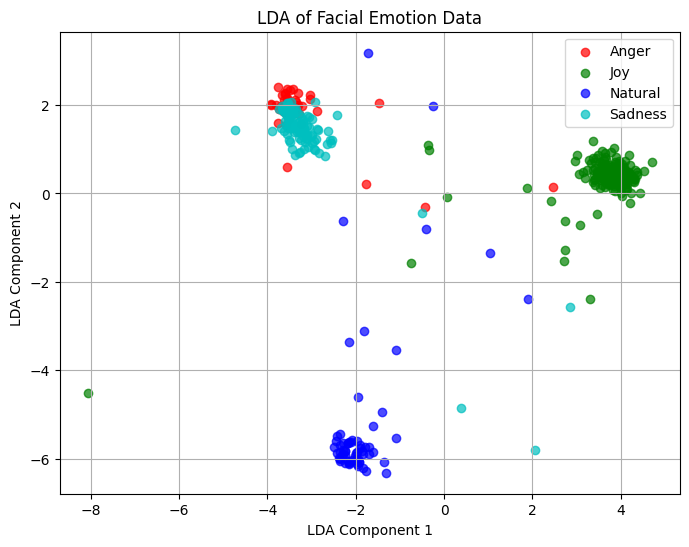

In [10]:
# Plot the LDA-transformed data
plt.figure(figsize=(8, 6))
colors = ['r', 'g', 'b', 'c', 'm', 'y']
for i, color in zip(range(len(CATEGORIES)), colors):
    plt.scatter(X_train_lda[y_train == i, 0], X_train_lda[y_train == i, 1], alpha=0.7, color=color, label=CATEGORIES[i])

plt.xlabel('LDA Component 1')
plt.ylabel('LDA Component 2')
plt.title('LDA of Facial Emotion Data')
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.grid(True)
plt.show()

## Fit to model

In [11]:
# One-hot encode labels
num_classes = len(CATEGORIES)
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [12]:
input_shape = X_train_lda.shape[1]
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(input_shape,)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.7),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(4, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_lda, y_train, epochs=50, batch_size=32, validation_data=(X_test_lda, y_test), shuffle=True)

Epoch 1/50


d:\FYP Face Recognition\virtual_env\Lib\site-packages\keras\src\layers\core\input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.2784 - loss: 2.1428 - val_accuracy: 0.4190 - val_loss: 1.3903
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4181 - loss: 1.5366 - val_accuracy: 0.4000 - val_loss: 1.3618
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5382 - loss: 1.2754 - val_accuracy: 0.4095 - val_loss: 1.3406
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6321 - loss: 1.0957 - val_accuracy: 0.4286 - val_loss: 1.3290
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6682 - loss: 0.9949 - val_accuracy: 0.3905 - val_loss: 1.3319
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6882 - loss: 0.8563 - val_accuracy: 0.4000 - val_loss: 1.3174
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7459 - loss: 0.7950 - val_accuracy: 0.3714 - val_loss: 1.3202
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7632 - loss: 0.7098 - val_accuracy: 0.3905 - val_loss: 1.3248
E

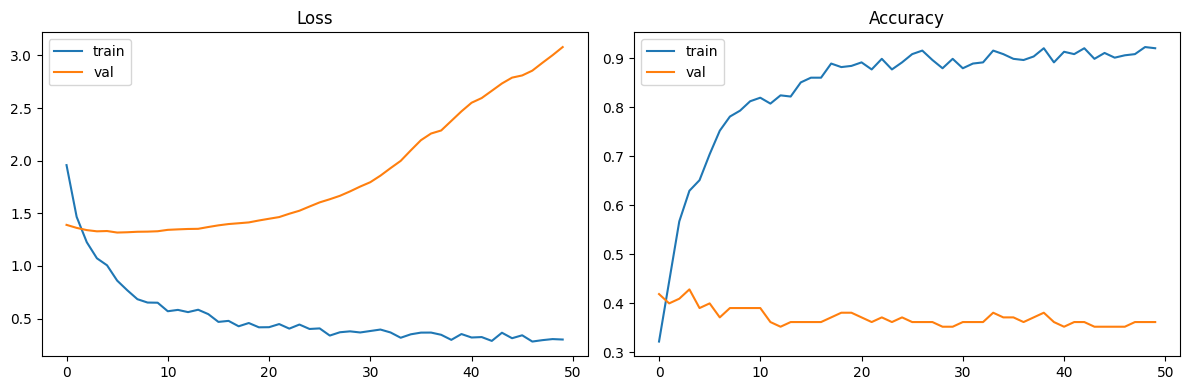

In [13]:
import matplotlib.pyplot as plt

def plot_learning_curves(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.title('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='val')
    plt.title('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_learning_curves(history)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Accuracy: 0.3619047619047619
              precision    recall  f1-score   support

       Anger       0.10      0.21      0.14        14
         Joy       0.81      0.48      0.60        46
     Natural       0.21      0.19      0.20        16
     Sadness       0.29      0.34      0.31        29

    accuracy                           0.36       105
   macro avg       0.35      0.31      0.31       105
weighted avg       0.48      0.36      0.40       105



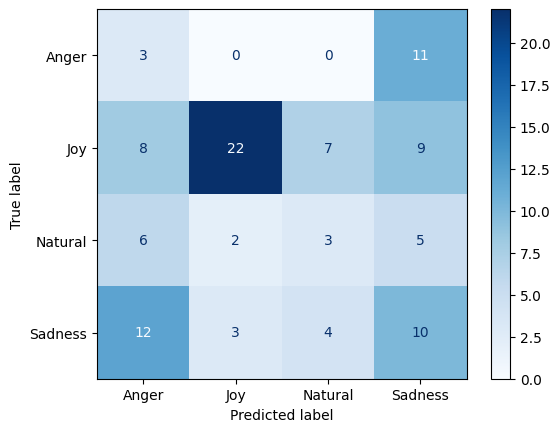

In [14]:
# Predict on the test set
y_pred_prob = model.predict(X_test_lda)
y_pred = np.argmax(y_pred_prob, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# Evaluate the model
accuracy = accuracy_score(y_test_labels, y_pred)
print(f'Accuracy: {accuracy}')
print(classification_report(y_test_labels, y_pred, target_names=CATEGORIES))

# Plot confusion matrix
cm = confusion_matrix(y_test_labels, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CATEGORIES)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [15]:
# Create a MLP classifier
from sklearn.neural_network import MLPClassifier


mlp = MLPClassifier(activation='relu', solver='adam', shuffle=True)
hist = mlp.fit(X_train_lda, y_train)

d:\FYP Face Recognition\virtual_env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy: 0.34285714285714286
              precision    recall  f1-score   support

       Anger       0.06      0.14      0.08        14
         Joy       0.83      0.54      0.66        46
     Natural       0.18      0.12      0.15        16
     Sadness       0.25      0.24      0.25        29

    accuracy                           0.34       105
   macro avg       0.33      0.26      0.28       105
weighted avg       0.47      0.34      0.39       105



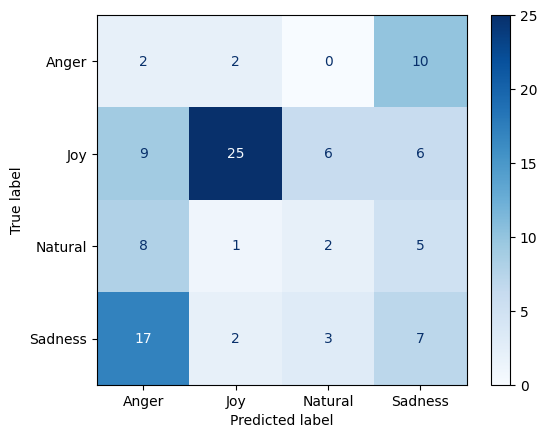

In [16]:
# Predict on the test set
y_pred_prob = mlp.predict(X_test_lda)
y_pred = np.argmax(y_pred_prob, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# Evaluate the model
accuracy = accuracy_score(y_test_labels, y_pred)
print(f'Accuracy: {accuracy}')
print(classification_report(y_test_labels, y_pred, target_names=CATEGORIES))

# Plot confusion matrix
cm = confusion_matrix(y_test_labels, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CATEGORIES)
disp.plot(cmap=plt.cm.Blues)
plt.show()